# Minplus algebra experiment

This code attempts to learn the 64D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 64

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 50       # beta of softplus
hidden = 200     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 7400.02685546875
iteration 0 loss 3585.72265625


iteration 5000 loss 0.5071010589599609


iteration 10000 loss 0.18863075971603394


iteration 15000 loss 0.12971098721027374


iteration 20000 loss 0.10829538106918335


iteration 25000 loss 0.09660936146974564


iteration 30000 loss 0.0705810934305191


iteration 35000 loss 0.06307349354028702


iteration 40000 loss 0.05711580067873001


iteration 45000 loss 0.05641162022948265


iteration 50000 loss 0.05731376260519028


iteration 55000 loss 0.04503115639090538


iteration 60000 loss 0.04198412597179413


iteration 65000 loss 0.041699375957250595


iteration 70000 loss 0.03778209909796715


iteration 75000 loss 0.040644433349370956


iteration 80000 loss 0.03215358778834343


iteration 85000 loss 0.11535734683275223


iteration 90000 loss 0.029586931690573692


iteration 95000 loss 0.0767790749669075


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.025653649121522903


iteration 105000 loss 0.02398511953651905


iteration 110000 loss 0.022109033539891243


iteration 115000 loss 0.02056027390062809


iteration 120000 loss 0.01919427514076233


iteration 125000 loss 0.01796518824994564


iteration 130000 loss 0.016893047839403152


iteration 135000 loss 0.0158095546066761


iteration 140000 loss 0.014856045134365559


iteration 145000 loss 0.01511387713253498


iteration 150000 loss 0.013429926708340645


iteration 155000 loss 0.012449895963072777


iteration 160000 loss 0.011762694455683231


iteration 165000 loss 0.011149420402944088


iteration 170000 loss 0.010564806871116161


iteration 175000 loss 0.010082739405333996


iteration 180000 loss 0.009541993029415607


iteration 185000 loss 0.2383555918931961


iteration 190000 loss 0.008889364078640938


iteration 195000 loss 0.008236498571932316


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.007851975969970226


iteration 205000 loss 0.007702392991632223


iteration 210000 loss 0.007345225196331739


iteration 215000 loss 0.0070006162859499454


iteration 220000 loss 0.006680051796138287


iteration 225000 loss 0.006381898187100887


iteration 230000 loss 0.006083949003368616


iteration 235000 loss 0.005799687001854181


iteration 240000 loss 0.005534754600375891


iteration 245000 loss 0.005286226514726877


iteration 250000 loss 0.005053089000284672


iteration 255000 loss 0.004829065408557653


iteration 260000 loss 0.004606503061950207


iteration 265000 loss 0.004404133651405573


iteration 270000 loss 0.004204144701361656


iteration 275000 loss 0.004012662451714277


iteration 280000 loss 0.0038388564717024565


iteration 285000 loss 0.003662740346044302


iteration 290000 loss 0.003504450898617506


iteration 295000 loss 0.003351328894495964


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0032053806353360415


iteration 305000 loss 0.0031335034873336554


iteration 310000 loss 0.002967199543491006


iteration 315000 loss 0.002813642378896475


iteration 320000 loss 0.0026694631669670343


iteration 325000 loss 0.0025355368852615356


iteration 330000 loss 0.0024097857531160116


iteration 335000 loss 0.0022912374697625637


iteration 340000 loss 0.0021798349916934967


iteration 345000 loss 0.002074223244562745


iteration 350000 loss 0.0019748834893107414


iteration 355000 loss 0.0018810676410794258


iteration 360000 loss 0.0017916755750775337


iteration 365000 loss 0.0017069788882508874


iteration 370000 loss 0.0016275352099910378


iteration 375000 loss 0.001551509485580027


iteration 380000 loss 0.0014789237175136805


iteration 385000 loss 0.001411130535416305


iteration 390000 loss 0.0013459458714351058


iteration 395000 loss 0.0012838125694543123


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0012255830224603415


iteration 405000 loss 0.001207306981086731


iteration 410000 loss 0.001169482246041298


iteration 415000 loss 0.0011335613671690226


iteration 420000 loss 0.0010990311857312918


iteration 425000 loss 0.0010657343082129955


iteration 430000 loss 0.0010335315018892288


iteration 435000 loss 0.001002342440187931


iteration 440000 loss 0.0009721241658553481


iteration 445000 loss 0.0009428239427506924


iteration 450000 loss 0.0009144310024566948


iteration 455000 loss 0.0008868857985362411


iteration 460000 loss 0.0008600660366937518


iteration 465000 loss 0.000833982543554157


iteration 470000 loss 0.0008086184388957918


iteration 475000 loss 0.0007839131867513061


iteration 480000 loss 0.0007599046803079545


iteration 485000 loss 0.0007365514757111669


iteration 490000 loss 0.0007138864020816982


iteration 495000 loss 0.0006918457802385092


L2 loss -- Plot

loss -67.82781982421875


loss -299.51544189453125


loss -430.3188171386719


loss -524.8703002929688


loss -609.58154296875


loss -688.577392578125


loss -761.5205078125


loss -825.6302490234375


loss -882.2556762695312


loss -929.4757080078125


loss -966.263671875


loss -994.0381469726562


loss -1016.0555419921875


loss -1031.6177978515625


loss -1041.4942626953125


loss -1047.1129150390625


loss -1050.015869140625


loss -1051.3306884765625


loss -1051.866455078125


loss -1052.082275390625


loss -1052.1580810546875


loss -1052.17822265625


loss -1052.1817626953125


loss -1052.1820068359375


loss -1052.1820068359375


loss -1052.18212890625


loss -1052.18212890625


loss -1052.18212890625


loss -1052.18212890625


loss -1052.1820068359375


loss -1052.18212890625


loss -1052.18212890625


loss -1052.18212890625


loss -1052.18212890625


loss -1052.18212890625


loss -1052.18212890625


loss -1052.1820068359375


loss -1052.18212890625


loss -1052.18212890625


loss -1052.18212890625


final mse:  3.52677673731705e-08
max, min: 6.7783093 -7.7547474
loss -67.82781982421875


loss -302.48895263671875


loss -433.9603576660156


loss -529.1644287109375


loss -614.3236083984375


loss -694.4678955078125


loss -770.5977783203125


loss -841.3050537109375


loss -903.4466552734375


loss -953.8197631835938


loss -993.73974609375


loss -1025.30078125


loss -1049.2059326171875


loss -1066.220947265625


loss -1077.6419677734375


loss -1084.6162109375


loss -1088.329345703125


loss -1090.2125244140625


loss -1091.0465087890625


loss -1091.35205078125


loss -1091.4510498046875


loss -1091.480224609375


loss -1091.487060546875


loss -1091.488037109375


loss -1091.488037109375


loss -1091.488037109375


loss -1091.488037109375


loss -1091.4881591796875


loss -1091.488037109375


loss -1091.488037109375


loss -1091.488037109375


loss -1091.488037109375


loss -1091.488037109375


loss -1091.488037109375


loss -1091.488037109375


loss -1091.488037109375


loss -1091.488037109375


loss -1091.488037109375


loss -1091.488037109375


loss -1091.488037109375


final mse:  2.5965618988266215e-08
max, min: 7.2320576 -7.8581095


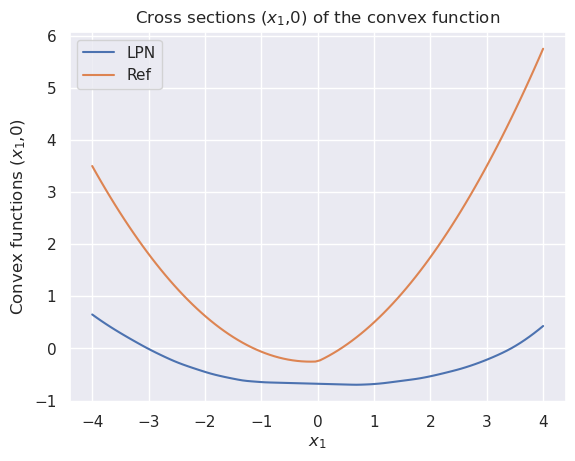

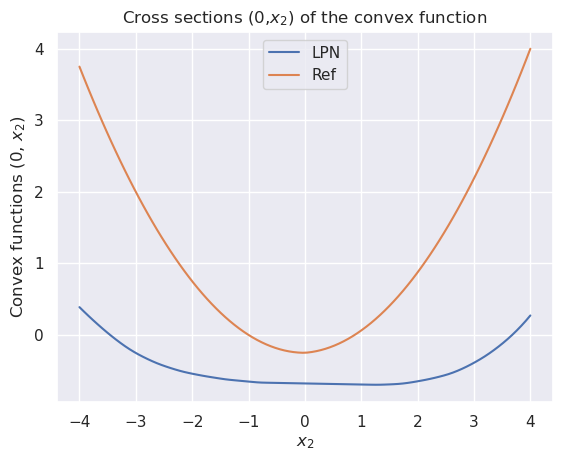

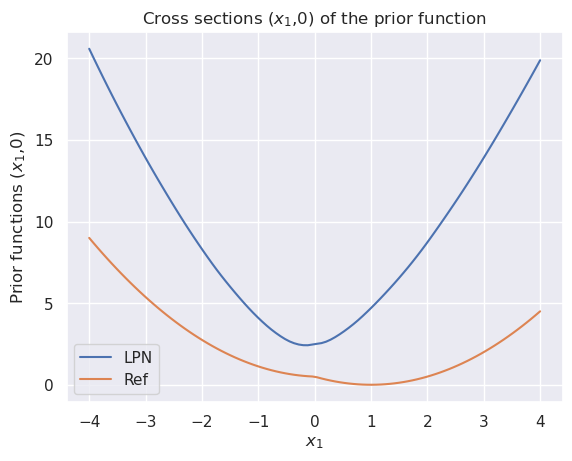

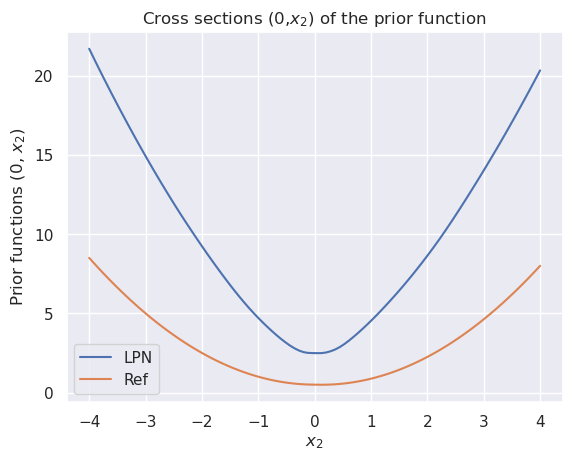

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([40000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 4870.49609375
iteration 0 loss 3264.3896484375


iteration 5000 loss 0.783604621887207


iteration 10000 loss 0.27462026476860046


iteration 15000 loss 0.17379313707351685


iteration 20000 loss 0.1332559585571289


iteration 25000 loss 0.11097563058137894


iteration 30000 loss 0.0969000905752182


iteration 35000 loss 0.08611389994621277


iteration 40000 loss 0.08182816952466965


iteration 45000 loss 0.07193085551261902


iteration 50000 loss 0.06582000106573105


iteration 55000 loss 0.05685511231422424


iteration 60000 loss 0.05201398953795433


iteration 65000 loss 0.043848924338817596


iteration 70000 loss 0.03891253471374512


iteration 75000 loss 0.03420050069689751


iteration 80000 loss 0.030263585969805717


iteration 85000 loss 0.0284561887383461


iteration 90000 loss 0.02471138909459114


iteration 95000 loss 0.02183757908642292


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0197275523096323


iteration 105000 loss 0.018304817378520966


iteration 110000 loss 0.016266165301203728


iteration 115000 loss 0.014748116955161095


iteration 120000 loss 0.01353560108691454


iteration 125000 loss 0.012380123138427734


iteration 130000 loss 0.01148943416774273


iteration 135000 loss 0.010723589919507504


iteration 140000 loss 0.010041925124824047


iteration 145000 loss 0.009200124070048332


iteration 150000 loss 0.008571630343794823


iteration 155000 loss 0.008051079697906971


iteration 160000 loss 0.00759059889242053


iteration 165000 loss 0.0071820951998233795


iteration 170000 loss 0.006814941298216581


iteration 175000 loss 0.0064809867180883884


iteration 180000 loss 0.00610502902418375


iteration 185000 loss 0.00581544591113925


iteration 190000 loss 0.005553935654461384


iteration 195000 loss 0.005314372479915619


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.005105169955641031


iteration 205000 loss 0.005017399322241545


iteration 210000 loss 0.004807240795344114


iteration 215000 loss 0.0046232701279222965


iteration 220000 loss 0.004448074381798506


iteration 225000 loss 0.004282738547772169


iteration 230000 loss 0.004131263121962547


iteration 235000 loss 0.003983472939580679


iteration 240000 loss 0.0038478649221360683


iteration 245000 loss 0.003724339883774519


iteration 250000 loss 0.003598238341510296


iteration 255000 loss 0.0034907308872789145


iteration 260000 loss 0.0033793302718549967


iteration 265000 loss 0.0032771239057183266


iteration 270000 loss 0.003178766230121255


iteration 275000 loss 0.00308542069979012


iteration 280000 loss 0.0029976563528180122


iteration 285000 loss 0.0029119979590177536


iteration 290000 loss 0.0028356423135846853


iteration 295000 loss 0.0027591323014348745


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0026827563997358084


iteration 305000 loss 0.0026597885880619287


iteration 310000 loss 0.0025636430364102125


iteration 315000 loss 0.0024692362640053034


iteration 320000 loss 0.0023799738846719265


iteration 325000 loss 0.002294303849339485


iteration 330000 loss 0.0022143858950585127


iteration 335000 loss 0.002139243297278881


iteration 340000 loss 0.0020681850146502256


iteration 345000 loss 0.0020016110502183437


iteration 350000 loss 0.0019381459569558501


iteration 355000 loss 0.001877928851172328


iteration 360000 loss 0.001822222606278956


iteration 365000 loss 0.0017680325545370579


iteration 370000 loss 0.0017171412473544478


iteration 375000 loss 0.001667157281190157


iteration 380000 loss 0.0016203174600377679


iteration 385000 loss 0.0015758983790874481


iteration 390000 loss 0.0015329207526519895


iteration 395000 loss 0.001492201816290617


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0014530221233144403


iteration 405000 loss 0.0014400056097656488


iteration 410000 loss 0.001416780287399888


iteration 415000 loss 0.0013947326224297285


iteration 420000 loss 0.001373453065752983


iteration 425000 loss 0.0013528023846447468


iteration 430000 loss 0.0013326707994565368


iteration 435000 loss 0.0013130027800798416


iteration 440000 loss 0.0012937566498294473


iteration 445000 loss 0.0012748929439112544


iteration 450000 loss 0.0012564100325107574


iteration 455000 loss 0.001238261698745191


iteration 460000 loss 0.001220456324517727


iteration 465000 loss 0.0012029705103486776


iteration 470000 loss 0.001185798435471952


iteration 475000 loss 0.0011689182138070464


iteration 480000 loss 0.0011523202992975712


iteration 485000 loss 0.0011359892087057233


iteration 490000 loss 0.0011199259897693992


iteration 495000 loss 0.0011041165562346578


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


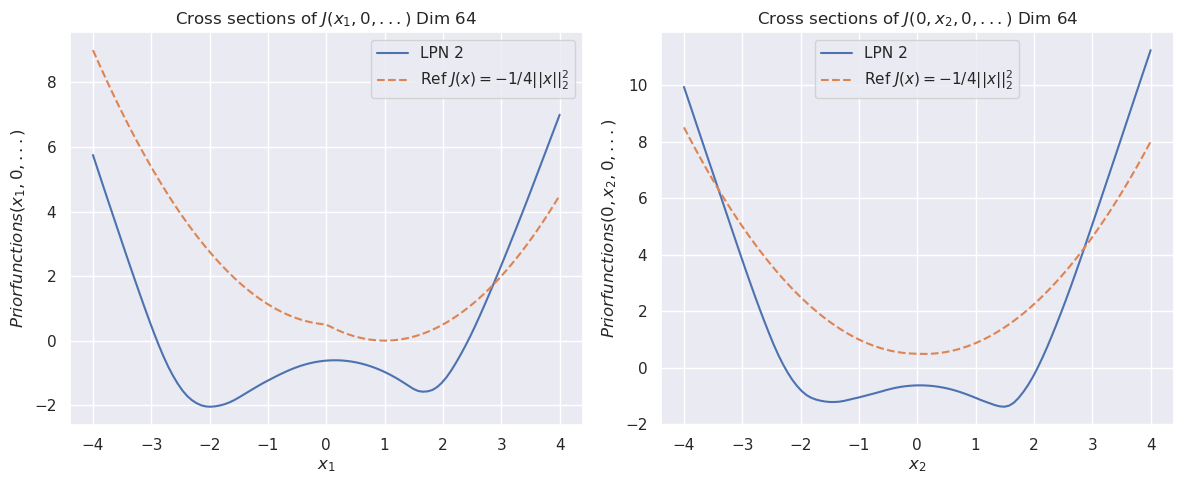

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)